In [2]:
%pip install mlxtend
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from mlxtend.plotting import plot_confusion_matrix

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model

physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Load and prep data

In [3]:
TRAIN_FILE_PATH = './train.csv'
TEST_FILE_PATH = './test.csv'

data = pd.read_csv(TRAIN_FILE_PATH)
testdata = pd.read_csv(TEST_FILE_PATH)

X_train = data['Title'] + " " + data['Description'] # Combine title and description (better accuracy than using them as separate features)
y_train = data['Class Index'].apply(lambda x: x-1).values # Class labels need to begin from 0

x_test = testdata['Title'] + " " + testdata['Description'] # Combine title and description (better accuracy than using them as separate features)
y_test = testdata['Class Index'].apply(lambda x: x-1).values # Class labels need to begin from 0

maxlen = X_train.map(lambda x: len(x.split())).max() # max length of sentences in train dataset
data.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


Tokenize and pad loaded text

In [4]:
vocab_size = 10000 # arbitrarily chosen
embed_size = 32 # arbitrarily chosen

# Create and fit tokenizer
tok = Tokenizer(num_words=vocab_size)
tok.fit_on_texts(X_train.values)

# Tokenize data
X_train = tok.texts_to_sequences(X_train)
x_test = tok.texts_to_sequences(x_test)

# Pad data
X_train = pad_sequences(X_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

In [5]:
model = Sequential()
model.add(Embedding(vocab_size, embed_size, input_length=maxlen))
model.add(Bidirectional(LSTM(128, return_sequences=True))) # bidirectional LSTMs since this isn't a timeseries problem
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dense(1024))
model.add(Dropout(0.25))
model.add(Dense(512))
model.add(Dropout(0.25))
model.add(Dense(256))
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax'))
model.summary()

/Users/suman/Desktop/ann-assignment/env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Compile and fit model

In [6]:
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        min_delta=1e-4,
        patience=4,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='.weights.h5',
        monitor='val_accuracy', 
        mode='max', 
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

In [7]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # sparse categorical crossentropy loss because data is not one-hot encoded
model.fit(X_train, y_train, batch_size=256, validation_data=(x_test, y_test), epochs=20, callbacks=callbacks)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 731ms/step - accuracy: 0.7214 - loss: 0.6720
Epoch 1: val_accuracy improved from -inf to 0.90513, saving model to .weights.h5
469/469 ━━━━━━━━━━━━━━━━━━━━ 353s 748ms/step - accuracy: 0.7217 - loss: 0.6715 - val_accuracy: 0.9051 - val_loss: 0.2777
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9266 - loss: 0.2191
Epoch 2: val_accuracy improved from 0.90513 to 0.91513, saving model to .weights.h5
469/469 ━━━━━━━━━━━━━━━━━━━━ 829s 2s/step - accuracy: 0.9266 - loss: 0.2191 - val_accuracy: 0.9151 - val_loss: 0.2553
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 766ms/step - accuracy: 0.9374 - loss: 0.1782
Epoch 3: val_accuracy did not improve from 0.91513
469/469 ━━━━━━━━━━━━━━━━━━━━ 368s 785ms/step - accuracy: 0.9374 - loss: 0.1782 - val_accuracy: 0.9111 - val_loss: 0.2610
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 762ms/step - accuracy: 0.9499 - loss: 0.1450
Epoch 4: val_accuracy did not improve from 0.91513
469/469 ━━━━━━━━━━━━━━━━

Load weights with best val accuracy

In [8]:
model.load_weights('.weights.h5')
model.save('model.hdf5')

Test model with some arbitrary data

In [9]:
labels = ['World News', 'Sports News', 'Business News', 'Science-Technology News']

test = ['New evidence of virus risks from wildlife trade', 'Coronavirus: Bank pumps £100bn into UK economy to aid recovery', 
        'Trump\'s bid to end Obama-era immigration policy ruled unlawful', 'David Luiz’s future with Arsenal to be decided this week']
test_seq = pad_sequences(tok.texts_to_sequences(test), maxlen=maxlen)
test_preds = [labels[np.argmax(i)] for i in model.predict(test_seq)]

for news, label in zip(test, test_preds):
    print('{} - {}'.format(news, label))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
New evidence of virus risks from wildlife trade - Science-Technology News
Coronavirus: Bank pumps £100bn into UK economy to aid recovery - Business News
Trump's bid to end Obama-era immigration policy ruled unlawful - World News
David Luiz’s future with Arsenal to be decided this week - World News


Plot confusion matrix

238/238 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step


<Figure size 640x480 with 0 Axes>

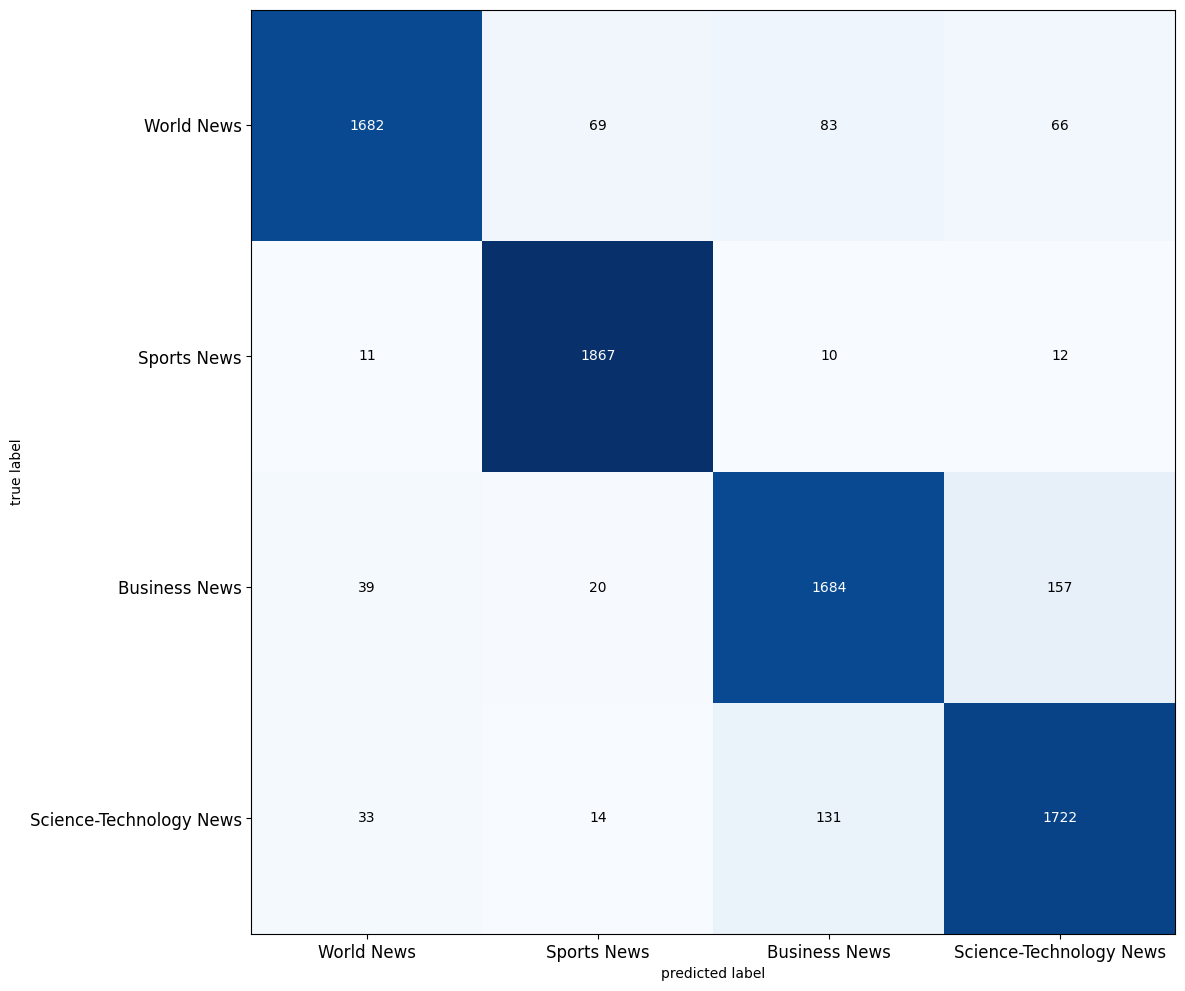

In [10]:
preds = [np.argmax(i) for i in model.predict(x_test)]
cm  = confusion_matrix(y_test, preds)
plt.figure()
plot_confusion_matrix(cm, figsize=(16,12), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(4), labels, fontsize=12)
plt.yticks(range(4), labels, fontsize=12)
plt.show()

Get precision and recall scores

In [11]:
print("Recall of the model is {:.2f}".format(recall_score(y_test, preds, average='micro')))
print("Precision of the model is {:.2f}".format(precision_score(y_test, preds, average='micro')))

Recall of the model is 0.92
Precision of the model is 0.92
